# Spark MLLib

- [Official documentation](http://spark.apache.org/docs/latest/ml-guide.html)
- [PySpark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html)

The MLLib library has two packages - `pyspark.mllib` which provides an RDD interface, and `pyspark.ml` which provides a DataFrame interface. we will focus only on the high-level interface.

Topics:

- Preparing a DataFrame for ML
- Generating simple statistics
- Splitting data
- Preprocessing
    - Feature extraction
    - Imputation
    - Transforms
- Unsupervised learning
- Supervised learning
    - Hyperparameter optimization
    - Using R formula
    - Evaluation
- Using pipelines

### Set up Spark and Spark SQL contexts

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = (
    SparkSession.builder 
    .master("local") 
    .appName("BIOS-823") 
    .config("spark.executor.cores", 4) 
    .getOrCreate()    
)

## Preparing a DataFrame for ML

Spark provides dense and sparse vectors and matrices mainly as data structures for ML, so even though they live in the `ml.linalg` module, the ability to manipulate them is very limited.

In [6]:
import numpy as np

In [7]:
from pyspark.ml.linalg import Vectors

### Vectors

In [8]:
v1 = Vectors.dense(range(1,11))
v2 = Vectors.dense(range(0, 10))

In [9]:
v1

DenseVector([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

In [10]:
v2

DenseVector([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

#### To numpy array

In [11]:
v1.array

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

#### Simple vector operations

In [12]:
v1.norm(p=1)

55.0

In [13]:
v1.sum()

55.0

In [14]:
v1.norm(p=2)

19.621416870348583

In [15]:
np.sqrt((v1*v1).sum())

19.621416870348583

In [16]:
v1.squared_distance(v2)

10.0

In [17]:
((v1 - v2).array**2).sum()

10.0

In [18]:
v1.dot(v2)

330.0

### Manual construction of an ML DaataFrame

ML operations generally require a DataFrame with columns corresponding to a a label and features represented as a Vector.

In [19]:
data =[
    (0.0, Vectors.dense([1,2,3])), 
    (1.0, Vectors.dense([2,3,4])),
    (0.0, Vectors.dense([3,4,5])),
    (1.0, Vectors.dense([2,2,2]))
]

df = spark.createDataFrame(data, ['label', 'features'])

In [20]:
df.show()

+-----+-------------+
|label|     features|
+-----+-------------+
|  0.0|[1.0,2.0,3.0]|
|  1.0|[2.0,3.0,4.0]|
|  0.0|[3.0,4.0,5.0]|
|  1.0|[2.0,2.0,2.0]|
+-----+-------------+



#### Converting to a standard DataFrame

In [21]:
from pyspark.ml.functions import vector_to_array

In [22]:
from pyspark.sql.functions import col

In [23]:
df.select('label', vector_to_array('features')).show()

+-----+---------------+
|label|  UDF(features)|
+-----+---------------+
|  0.0|[1.0, 2.0, 3.0]|
|  1.0|[2.0, 3.0, 4.0]|
|  0.0|[3.0, 4.0, 5.0]|
|  1.0|[2.0, 2.0, 2.0]|
+-----+---------------+



In [24]:
df.withColumn("xs", vector_to_array("features")).show()

+-----+-------------+---------------+
|label|     features|             xs|
+-----+-------------+---------------+
|  0.0|[1.0,2.0,3.0]|[1.0, 2.0, 3.0]|
|  1.0|[2.0,3.0,4.0]|[2.0, 3.0, 4.0]|
|  0.0|[3.0,4.0,5.0]|[3.0, 4.0, 5.0]|
|  1.0|[2.0,2.0,2.0]|[2.0, 2.0, 2.0]|
+-----+-------------+---------------+



In [25]:
df.withColumn("xs", vector_to_array("features")).dtypes

[('label', 'double'), ('features', 'vector'), ('xs', 'array<double>')]

In [26]:
(
    df.
    withColumn("xs", vector_to_array("features")).
    select(["label"] + [col("xs")[i] for i in range(3)])
).show()

+-----+-----+-----+-----+
|label|xs[0]|xs[1]|xs[2]|
+-----+-----+-----+-----+
|  0.0|  1.0|  2.0|  3.0|
|  1.0|  2.0|  3.0|  4.0|
|  0.0|  3.0|  4.0|  5.0|
|  1.0|  2.0|  2.0|  2.0|
+-----+-----+-----+-----+



### Using VectorAssembler

In [27]:
from pyspark.ml.feature import VectorAssembler

In [28]:
import pandas as pd

In [29]:
url = 'https://bit.ly/3eoBK6t'
pdf = pd.read_csv(url)

In [30]:
pdf.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [31]:
iris = spark.createDataFrame(pdf)

In [32]:
iris.show(3)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 3 rows



In [33]:
iris.columns[:-1]

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [34]:
assembler = VectorAssembler(
    inputCols=iris.columns[:-1],
    outputCol='raw_features')
df = assembler.transform(iris)

In [35]:
df.show(3)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|     raw_features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 3 rows



### Generating simple statistics

In [36]:
import pyspark.ml.stat as stat 

In [37]:
df.select(stat.Summarizer.mean(col('raw_features'))).show()

+--------------------+
|  mean(raw_features)|
+--------------------+
|[5.84333333333333...|
+--------------------+



In [38]:
(
    df.select(
        stat.Summarizer.metrics('std', 'min', 'max', 'mean').
        summary(col('raw_features'))).
    show(truncate=False)
)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|aggregate_metrics(raw_features, 1.0)                                                                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[0.8280661279778628,0.43359431136217363,1.7644204199522624,0.7631607417008414], [4.3,2.0,1.0,0.1], [7.9,4.4,6.9,2.5], [5.843333333333335,3.0540000000000003,3.758666666666667,1.1986666666666668]]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



### Split data

In [39]:
train_data, test_data = df.randomSplit(weights=[2.,1.], seed=0)

In [40]:
train_data.count(), test_data.count()

(98, 52)

In [41]:
train_data.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|
+------------+-----------+------------+-----------+----------+-----------------+
|         5.0|        3.4|         1.5|        0.2|    setosa|[5.0,3.4,1.5,0.2]|
|         5.4|        3.7|         1.5|        0.2|    setosa|[5.4,3.7,1.5,0.2]|
|         4.8|        3.0|         1.4|        0.1|    setosa|[4.8,3.0,1.4,0.1]|
|         4.8|        3.4|         1.9|        0.2|    setosa|[4.8,3.4,1.9,0.2]|
|         4.9|        3.1|         1.5|        0.1|    setosa|[4.9,3.1,1.5,0.1]|
|         5.2|        4.1|         1.5|        0.1|    setosa|[5.2,4.1,1.5,0.1]|
|         5.4|        3.4|         1.5|        0.4|    setosa|[5.4,3.4,1.5,0.4]|
|         5.6|        3.0|         4.5|        1.5|versicolor|[5.6,3.0,4.5,1.5]|
|         5.8|        2.7|         4.1|        1.0|versicolor|[5.8,2.7,4.1,1.0]|
|         6.1|        2.9|  

In [42]:
test_data.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|
+------------+-----------+------------+-----------+----------+-----------------+
|         5.0|        3.6|         1.4|        0.2|    setosa|[5.0,3.6,1.4,0.2]|
|         5.2|        3.5|         1.5|        0.2|    setosa|[5.2,3.5,1.5,0.2]|
|         4.9|        2.4|         3.3|        1.0|versicolor|[4.9,2.4,3.3,1.0]|
|         6.3|        2.9|         5.6|        1.8| virginica|[6.3,2.9,5.6,1.8]|
|         7.2|        3.2|         6.0|        1.8| virginica|[7.2,3.2,6.0,1.8]|
|         6.7|        3.3|         5.7|        2.5| virginica|[6.7,3.3,5.7,2.5]|
+------------+-----------+------------+-----------+----------+-----------------+



In [43]:
train_data = train_data.persist()

## Processing data

### Encoding categorical features

In [44]:
from pyspark.ml.feature import StringIndexer

In [45]:
indexer = StringIndexer(inputCol='species', outputCol='label')

In [46]:
indexer = indexer.fit(train_data)

In [47]:
train_df = indexer.transform(train_data)
test_df = indexer.transform(test_data)

In [48]:
train_df.sample(0.1).show()

+------------+-----------+------------+-----------+----------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|   species|     raw_features|label|
+------------+-----------+------------+-----------+----------+-----------------+-----+
|         4.6|        3.4|         1.4|        0.3|    setosa|[4.6,3.4,1.4,0.3]|  0.0|
|         4.9|        3.0|         1.4|        0.2|    setosa|[4.9,3.0,1.4,0.2]|  0.0|
|         4.7|        3.2|         1.6|        0.2|    setosa|[4.7,3.2,1.6,0.2]|  0.0|
|         6.6|        2.9|         4.6|        1.3|versicolor|[6.6,2.9,4.6,1.3]|  1.0|
|         5.6|        2.5|         3.9|        1.1|versicolor|[5.6,2.5,3.9,1.1]|  1.0|
|         5.9|        3.0|         4.2|        1.5|versicolor|[5.9,3.0,4.2,1.5]|  1.0|
|         6.2|        2.2|         4.5|        1.5|versicolor|[6.2,2.2,4.5,1.5]|  1.0|
|         6.7|        3.1|         4.4|        1.4|versicolor|[6.7,3.1,4.4,1.4]|  1.0|
|         6.4|        2.9|         4.3|    

### Scaling

In [49]:
from pyspark.ml.feature import StandardScaler

In [50]:
scaler = StandardScaler(withMean=True,
                        withStd=True,
                        inputCol='raw_features',
                        outputCol='features')

In [51]:
scaler = scaler.fit(train_df)

In [52]:
train_df_scaled = scaler.transform(train_df)
test_df_scaled = scaler.transform(test_df)

In [53]:
train_df_scaled.select('features', 'features').show(5, truncate=False)

+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|features                                                                         |features                                                                         |
+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|[-1.5213158492369616,0.00692241917037384,-1.2132855899947563,-1.22045281288949]  |[-1.5213158492369616,0.00692241917037384,-1.2132855899947563,-1.22045281288949]  |
|[-1.5213158492369616,0.6853194978669278,-1.2714283713245784,-1.0882932817699649] |[-1.5213158492369616,0.6853194978669278,-1.2714283713245784,-1.0882932817699649] |
|[-1.390075573510533,0.23305477873589214,-1.3295711526544005,-1.22045281288949]   |[-1.390075573510533,0.23305477873589214,-1.3295711526544005,-1.22045281288949]   |
|[-1

## Unsupervised learning

### Dimension reduction

In [54]:
from pyspark.ml.feature import PCA

In [55]:
pca = PCA(k=2, inputCol='features', outputCol='pc').fit(train_df_scaled)

In [56]:
train_df_scaled = pca.transform(train_df_scaled)

In [57]:
train_df_scaled.select('pc').show(5, truncate=False)

+----------------------------------------+
|pc                                      |
+----------------------------------------+
|[2.1719561815281754,0.7342240484007609] |
|[2.3257684348824283,0.11499107410380768]|
|[2.2379887825335114,0.47537636776842684]|
|[1.9410238356438345,0.7700780683206433] |
|[2.0469675488421304,0.5739261085291683] |
+----------------------------------------+
only showing top 5 rows



In [58]:
import matplotlib.pyplot as plt

In [59]:
pdf = (
    train_df_scaled.select('label', 'pc').
    withColumn("pc", vector_to_array("pc")).
    select(["label"] + [col("pc")[i] for i in range(2)])
).toPandas()

In [60]:
pdf.head(3)

,label,pc[0],pc[1]
0,0.0,2.171956,0.734224
1,0.0,2.325768,0.114991
2,0.0,2.237989,0.475376


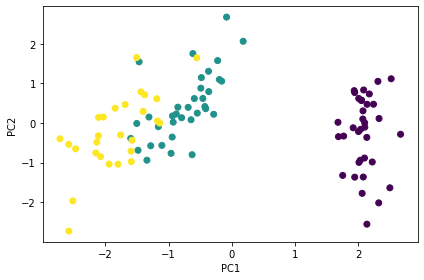

In [61]:
plt.scatter(pdf.iloc[:, 1], pdf.iloc[:, 2], c=pdf.iloc[:, 0])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

### Clustering

In [62]:
from pyspark.ml.clustering import GaussianMixture

In [63]:
gmm = GaussianMixture(
    featuresCol='features',
    k=3, 
    seed=0)

In [64]:
gmm = gmm.fit(train_df_scaled)

In [65]:
gmm.gaussiansDF.toPandas()

,mean,cov
0,"[-0.9380257346418976, 0.8046671327476248, -1.2...","DenseMatrix([[0.2166823 , 0.29970786, 0.013235..."
1,"[0.005938775919945091, -0.5221004264901148, 0....","DenseMatrix([[ 0.10356088, -0.0849359 , 0.056..."
2,"[0.6061006081018865, -0.4609677242002642, 0.72...","DenseMatrix([[0.65443637, 0.40398667, 0.255851..."


In [66]:
train_df_scaled = gmm.transform(train_df_scaled)

In [67]:
train_df_scaled.select('features', 'label', 'probability', 'prediction').sample(0.1).show()

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|[-1.5213158492369...|  0.0|[0.99999999999278...|         0|
|[-0.2089130919726...|  1.0|[5.51104734455841...|         1|
|[-0.0776728162462...|  1.0|[6.94499110009014...|         1|
|[0.70976883811231...|  2.0|[9.24177181915992...|         2|
|[2.02217159537659...|  2.0|[2.49896507749226...|         2|
|[0.31604801093303...|  2.0|[6.91948378303032...|         2|
+--------------------+-----+--------------------+----------+



## Supervised Learning

In [68]:
train_df_scaled = train_df_scaled.select('features', 'label')

In [69]:
test_df_scaled = test_df_scaled.select('features', 'label')

In [70]:
from pyspark.ml.classification import RandomForestClassifier

In [71]:
rf = RandomForestClassifier(
    numTrees=10,
    maxDepth=3,
    seed=0
)

In [72]:
rf = rf.fit(train_df_scaled)

In [73]:
test_df_scaled = rf.transform(test_df_scaled)

In [74]:
test_df_scaled.sample(0.1).show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.31604801093303...|  1.0|[0.03030303030303...|[0.00303030303030...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+



### Model evaluation

In [75]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [76]:
evaluator = MulticlassClassificationEvaluator()

#### Default is f1 score

In [77]:
evaluator.evaluate(test_df_scaled)

0.9618662587412588

In [78]:
evaluator = evaluator.setMetricName('accuracy')

In [79]:
evaluator.evaluate(test_df_scaled)

0.9615384615384616

### Pipelines

We can assemble pipeline for convenience and reproducibility. This is very similar to what you would do with `sklearn`, except that MLLib allows you to handle massive datasets by distributing the analysis to multiple computers.

We will put all the preceding steps into the pipeline, and also add hyperparameter optimization via cross-validation.

In [80]:
from pyspark.ml import Pipeline

In [81]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [82]:
assembler = VectorAssembler(
    inputCols=iris.columns[:-1],
    outputCol='raw_features'
)
scaler = StandardScaler(
    withMean=True, 
    withStd=True, 
    inputCol='raw_features', 
    outputCol='features'
)
indexer = StringIndexer(
    inputCol="species", 
    outputCol="label"
)
rf = RandomForestClassifier()
params = (
    ParamGridBuilder().
    addGrid(rf.numTrees, [5,10,25]).
    addGrid(rf.maxDepth, [3,4,5]).
    build()
)
evaluator = MulticlassClassificationEvaluator(
    metricName='accuracy'
)
cv = CrossValidator(
    estimator=rf,
    evaluator=evaluator,
    estimatorParamMaps=params,
    numFolds=3,
    seed=0
).setParallelism(4)

In [83]:
pipeline = Pipeline(
    stages=[assembler, scaler, indexer, cv]
)

In [84]:
train_iris, test_iris = iris.randomSplit([2.0, 1.0], seed=0)

In [85]:
model = pipeline.fit(train_iris)

#### Accessing pipeline stages

In [86]:
model.stages

[VectorAssembler_b707c6dd0daa,
 StandardScalerModel: uid=StandardScaler_6f905091c141, numFeatures=4, withMean=true, withStd=true,
 StringIndexerModel: uid=StringIndexer_680263d99f3c, handleInvalid=error,
 CrossValidatorModel_a1e2fa6e9d8f]

In [87]:
df_cv = pd.DataFrame(list(zip(model.stages[3].getEstimatorParamMaps(), model.stages[3].avgMetrics)))
df_cv[['numTrees', 'maxDepth']] = df_cv[0].apply(lambda x: pd.Series(list(x.values())))
df_cv = df_cv.drop(0, axis=1)
df_cv = df_cv.iloc[:, [1,2,0]]
df_cv.columns = df_cv.columns[:2].tolist() + ['accuracy']
df_cv.sort_values('accuracy', ascending=False)

,numTrees,maxDepth,accuracy
6,25,3,0.958970
7,25,4,0.958970
8,25,5,0.958970
5,10,5,0.948217
2,5,5,0.941426
0,5,3,0.940685
3,10,3,0.936723
4,10,4,0.936723
1,5,4,0.929932


#### Evaluate model on test data

In [88]:
prediction = model.transform(test_iris)

In [89]:
evaluator.evaluate(prediction)

0.9807692307692307

## Using Spark for non-MLLib models

We can also run non-MLLIB machine learning algorithms using Spark.

### Hyper-parameter optimization

In [90]:
! python3 -m pip install --quiet joblibspark

#### Scikit-learn

In [91]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import parallel_backend
from joblibspark import register_spark

In [92]:
url = 'https://bit.ly/3eoBK6t'
iris = pd.read_csv(url)

X = iris.iloc[:, :-1]
y = iris.species.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
svc = SVC(random_state=0)
params = dict(
    C = [0.1, 1, 10],
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
)
cv = GridSearchCV(svc, params, cv=3)

In [94]:
register_spark()

In [95]:
with parallel_backend('spark', n_jobs=4):
    cv.fit(X_train, y_train)

In [96]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003228,0.000145,0.002065,0.000645,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.973684,0.972973,0.972973,0.973210,0.000335,3
1,0.003249,0.000082,0.001860,0.000418,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.973684,0.972973,0.972973,0.973210,0.000335,3
2,0.003456,0.000053,0.001981,0.000424,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.763158,0.864865,0.756757,0.794927,0.049523,9
3,0.003865,0.000290,0.002149,0.000506,0.1,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",0.368421,0.351351,0.351351,0.357041,0.008047,10
4,0.003543,0.000460,0.002302,0.000091,1,linear,"{'C': 1, 'kernel': 'linear'}",1.000000,0.972973,0.972973,0.981982,0.012741,1
5,0.003509,0.000452,0.002630,0.000460,1,poly,"{'C': 1, 'kernel': 'poly'}",0.947368,0.945946,0.972973,0.955429,0.012419,6
6,0.003940,0.000466,0.002706,0.000336,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.973684,0.972973,0.972973,0.973210,0.000335,3
7,0.004211,0.000627,0.003025,0.000451,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.368421,0.351351,0.351351,0.357041,0.008047,10
8,0.003760,0.000423,0.002659,0.000333,10,linear,"{'C': 10, 'kernel': 'linear'}",0.947368,0.972973,0.918919,0.946420,0.022078,7
9,0.004453,0.000755,0.002508,0.000103,10,poly,"{'C': 10, 'kernel': 'poly'}",0.921053,0.972973,0.918919,0.937648,0.024994,8


#### Optuna

In [97]:
url = 'https://bit.ly/3eoBK6t'
iris = pd.read_csv(url)

X = iris.iloc[:, :-1]
y = iris.species.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [98]:
n, p = X_train.shape

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [100]:
import optuna

class Objective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        X, y = self.X, self.y # load data once only

        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        n_estimators = trial.suggest_int('n_estimators', 50, 201)
        max_features = trial.suggest_float('max_features', 1/p, 1)
        max_depth = trial.suggest_float('max_depth', 1, 128, log=True)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 11, 1)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11, 1)

        clf = RandomForestClassifier(
            criterion = criterion,
            n_estimators = n_estimators,
            max_features = max_features,
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
        )

        score = cross_val_score(clf, X, y,  cv=5).mean()
        return score
    
objective =  Objective(X_train, y_train)
study = optuna.create_study(direction='maximize', storage='sqlite:///memory')

n_jobs = 4
with parallel_backend('spark', n_jobs=n_jobs):
    study.optimize(objective, n_trials=100, n_jobs=n_jobs)

[I 2020-11-04 12:47:30,511] A new study created in RDB with name: no-name-97aab8f6-8b87-4d03-afe2-5f85415b9671


In [101]:
study.trials_dataframe().head(10)

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
0,0,0.804348,2020-11-04 12:47:31.659174,2020-11-04 12:47:32.204716,0 days 00:00:00.545542,entropy,1.966860,0.457199,9,8,74,COMPLETE
1,1,0.964032,2020-11-04 12:47:31.659435,2020-11-04 12:47:32.745937,0 days 00:00:01.086502,gini,1.792140,0.997070,1,10,147,COMPLETE
2,2,0.955336,2020-11-04 12:47:31.659935,2020-11-04 12:47:32.810389,0 days 00:00:01.150454,entropy,118.759561,0.262684,1,8,146,COMPLETE
3,3,0.964427,2020-11-04 12:47:31.660439,2020-11-04 12:47:32.619121,0 days 00:00:00.958682,gini,4.435854,0.761082,7,4,128,COMPLETE
4,4,0.964427,2020-11-04 12:47:33.254434,2020-11-04 12:47:34.555648,0 days 00:00:01.301214,entropy,15.285156,0.795445,6,10,180,COMPLETE
5,5,0.937154,2020-11-04 12:47:33.691416,2020-11-04 12:47:34.149519,0 days 00:00:00.458103,gini,9.179145,0.301613,10,3,60,COMPLETE
6,6,0.964427,2020-11-04 12:47:33.780986,2020-11-04 12:47:34.522994,0 days 00:00:00.742008,gini,21.264760,0.675328,5,8,102,COMPLETE
7,7,0.964427,2020-11-04 12:47:33.831960,2020-11-04 12:47:34.710602,0 days 00:00:00.878642,gini,4.772650,0.518421,2,9,119,COMPLETE
8,8,0.955336,2020-11-04 12:47:35.174596,2020-11-04 12:47:36.389685,0 days 00:00:01.215089,entropy,30.773008,0.600859,8,5,175,COMPLETE
9,9,0.855336,2020-11-04 12:47:35.531175,2020-11-04 12:47:36.231259,0 days 00:00:00.700084,entropy,1.937602,0.955016,6,10,99,COMPLETE


### Using spark with a non-MLLib classifier

While there is no easy way to train a general ML model in parallel, we can use Spark for distributed predictions once the model is trained,

In [102]:
url = 'https://bit.ly/3eoBK6t'
iris = pd.read_csv(url)

X = iris.iloc[:, :-1]
y = iris.species.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Train scikit-learn model

We use the best parameters found by Optuna in the distributed hyperparameter optimization above.

In [103]:
study.best_params

{'criterion': 'gini',
 'max_depth': 4.435854141101209,
 'max_features': 0.7610816811817611,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 128}

In [104]:
rf = RandomForestClassifier(**study.best_params, random_state=0)

In [105]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4.435854141101209,
                       max_features=0.7610816811817611, min_samples_leaf=7,
                       min_samples_split=4, n_estimators=128, random_state=0)

In [106]:
from joblib import dump, load

dump(rf, 'rf.joblib') 

['rf.joblib']

In [107]:
def predict(iterartor):
    model = load('rf.joblib') # model is only loaded once
    for features in iterartor:
        yield pd.DataFrame(model.predict(features))

In [108]:
df = spark.createDataFrame(X_test)

In [109]:
help(df.mapInPandas)

Help on method mapInPandas in module pyspark.sql.pandas.map_ops:

mapInPandas(func, schema) method of pyspark.sql.dataframe.DataFrame instance
    Maps an iterator of batches in the current :class:`DataFrame` using a Python native
    function that takes and outputs a pandas DataFrame, and returns the result as a
    :class:`DataFrame`.
    
    The function should take an iterator of `pandas.DataFrame`\s and return
    another iterator of `pandas.DataFrame`\s. All columns are passed
    together as an iterator of `pandas.DataFrame`\s to the function and the
    returned iterator of `pandas.DataFrame`\s are combined as a :class:`DataFrame`.
    Each `pandas.DataFrame` size can be controlled by
    `spark.sql.execution.arrow.maxRecordsPerBatch`.
    
    :param func: a Python native function that takes an iterator of `pandas.DataFrame`\s, and
        outputs an iterator of `pandas.DataFrame`\s.
    :param schema: the return type of the `func` in PySpark. The value can be either a
      

In [110]:
pred = df.mapInPandas(predict, 'pred double')

#### Prediction from local copy

In [111]:
rf.predict(X_test)[:5]

array([2, 1, 1, 1, 1], dtype=int8)

#### Prediction on spark cluster

In [112]:
pred.show(5)

+----+
|pred|
+----+
| 2.0|
| 1.0|
| 1.0|
| 1.0|
| 1.0|
+----+
only showing top 5 rows

